# Automatic Differentiation with PyTorch

In this notebook, we will go through a small practical example to get familiar with PyTorch tensors and their gradients.


In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, random_split

seed = 2025
torch.set_default_dtype(torch.float32)
gen = torch.manual_seed(seed)

Uncomment and run the following cell to make the plots interactive. This is not necessary, but helps with viewing the 3D plots:

In [2]:
# %matplotlib widget

# Dataset

This is just a small demo example. We generate a dataset with a known distribution ($p^*$) with parameters $\mathbf{\theta}^* = (1.5, -0.5)$ and some uniform noise.

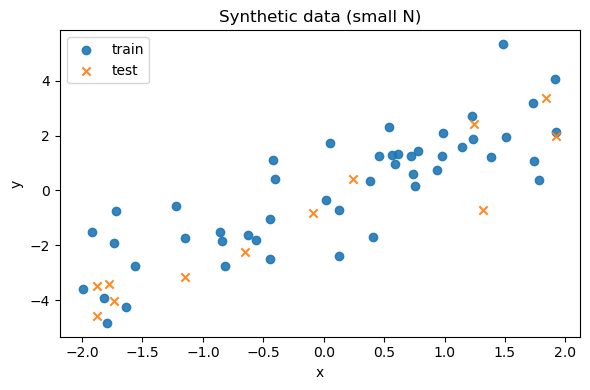

In [3]:
theta_star  = (1.5, -0.5)
def make_dataset():
    n = 60
    x = -2 + 4*torch.rand(n)
    
    y = theta_star[0] * x + theta_star[1] + 1.2 * torch.randn(n)
    return x, y

x, y = make_dataset()
ds = TensorDataset(x.unsqueeze(1), y.unsqueeze(1))

train_ds, test_ds = random_split(ds, [0.8, 0.2])

train_idx = torch.tensor(train_ds.indices)
test_idx  = torch.tensor(test_ds.indices)

x_train, y_train = x[train_idx], y[train_idx]
x_test,  y_test  = x[test_idx],  y[test_idx]


plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, label="train", alpha=0.9)
plt.scatter(x_test, y_test, label="test", alpha=0.9, marker="x")
plt.title("Synthetic data (small N)")
plt.xlabel("x"); 
plt.ylabel("y"); 
plt.legend(); 
plt.tight_layout(); 
plt.show()



# Model
A simple model for this problem is a Linear Regression. We can define our model with the parameter vector $\theta$ as:
\begin{align*}
f_\theta(x) = \theta_1 x + \theta_2
\end{align*}
# Loss function

As a loss function, we will use MSE-loss: $\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} ( f_{\theta}(x^{(i)}) - y^{(i)})^2$

Note that this is equivalent as using the squared error as single sample loss $\ell(f_\theta(x), y) = (f_\theta(x) - y)^2$ averaged over all samples.


The broadcasting ([..., None] - syntax) is just an implementation detail you do not need to worry about.

In [4]:

def mse_loss(theta, x, y):
    residuals = (theta[0][..., None] * x + theta[1][..., None] - y) 
    return (residuals ** 2).mean(dim=-1) # reduce over samples only


Some functions for plotting (you dont need to worry about):


In [5]:

def loss_surface_grid(x, y, loss_fn=mse_loss, w_lim=(-3.5, 3.5), b_lim=(-3.5, 3.5), n=120):
    w_lin = torch.linspace(w_lim[0], w_lim[1], n)
    b_lin = torch.linspace(b_lim[0], b_lim[1], n)
    W, B = torch.meshgrid(w_lin, b_lin, indexing="ij")
    with torch.no_grad():
        L = loss_fn((W, B), x, y)  # uses the same loss function
    return W, B, L

def plot_loss_surface_3d(x, y, title, grad=None, origin=None, w_lim=(-3.5, 3.5), b_lim=(-3.5, 3.5), n=120):
    W, B, L = loss_surface_grid(x, y, w_lim=w_lim, b_lim=b_lim, n=n)
    fig = plt.figure(figsize=(6, 4.5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(W.numpy(), B.numpy(), L.numpy(), alpha=0.8, linewidth=0, antialiased=True)
    
    if origin is not None:
        L0 = mse_loss(origin, x, y).item()
        ax.scatter([origin[0].item()], [origin[1].item()], [L0], color='red', s=50, label='evaluation point')

    
    if grad is not None:
        g_w, g_b = grad
        scale = .3
        ax.quiver(
            origin[0].item(), origin[1].item(), L0,
            g_w * scale, g_b * scale, 0.0,
            color='red', arrow_length_ratio=0.2, linewidth=2, label='gradient direction'
        )
        
    
    ax.set_xlabel(r"$\theta_1$") 
    ax.set_ylabel(r"$\theta_2$")
    ax.set_zlabel("MSE")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_overlapped_surface_3d(
    x_train, y_train, x_test, y_test, 
    w_lim=(-3.5, 3.5), b_lim=(-3.5, 3.5), n=120, alpha=0.65
):
    train_color, test_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    W, B, L_train = loss_surface_grid(x_train, y_train, w_lim=w_lim, b_lim=b_lim, n=n)
    _,  _, L_test  = loss_surface_grid(x_test,  y_test,  w_lim=w_lim, b_lim=b_lim, n=n)
    
    fig = plt.figure(figsize=(7, 5.2))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(W.numpy(), B.numpy(), L_train.numpy(), color=train_color, alpha=alpha, linewidth=0, antialiased=True)
    ax.plot_surface(W.numpy(), B.numpy(), L_test.numpy(),  color=test_color,  alpha=alpha, linewidth=0, antialiased=True)
    
    ax.set_xlabel(r"$\theta_1$"); 
    ax.set_ylabel(r"$\theta_2$"); 
    ax.set_zlabel("MSE")
    ax.set_title("Overlapped 3D MSE surfaces – TRAIN vs TEST")
    
    # Legend proxies
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0], [0], color=train_color, lw=6, label='train surface'),
        Line2D([0], [0], color=test_color,  lw=6, label='test surface'),
    ]
    ax.legend(handles=legend_elems, loc='upper left')
    plt.tight_layout()
    plt.show()




Next, we want to look at the so called Loss Landscape, a visualizaiton of the loss function with regards to the parameters. Since our parameter vector is two-dimensional, we can simply plot this in a 3D plot.

Of course, the loss is different for each sample. We can plot a single loss $\ell(f_\theta(x), y)$, or the average loss over the train or test set $\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \ell( f_{\theta}(x^{(i)}), y^{(i)})$

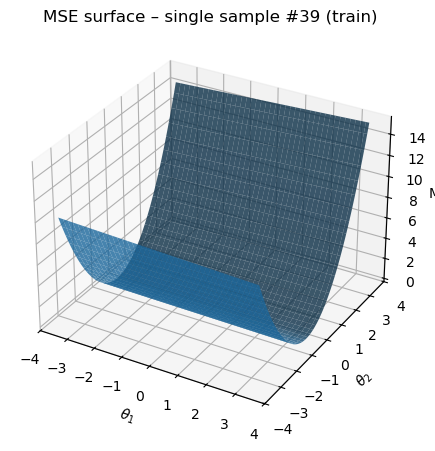

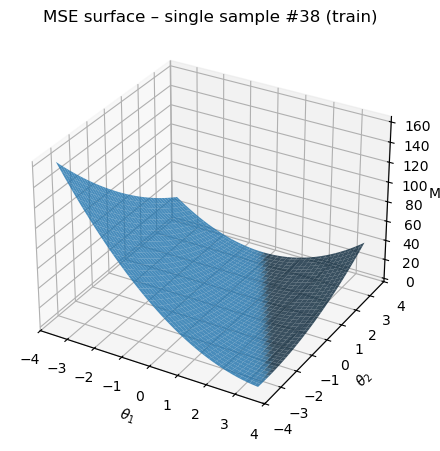

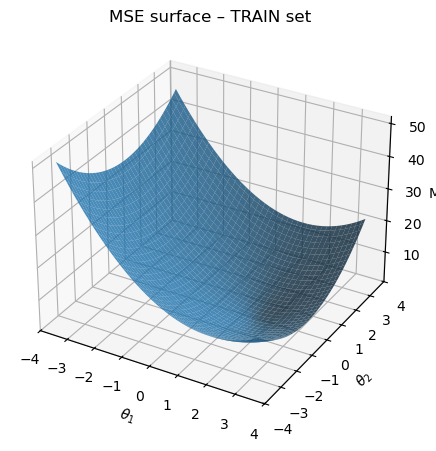

In [6]:
sample = int(torch.randint(2, len(x_train), (1,), generator=gen))


plot_loss_surface_3d(x_train[sample-1:sample], y_train[sample-1:sample], title=f'MSE surface – single sample #{sample} (train)')
plot_loss_surface_3d(x_train[sample-2:sample-1], y_train[sample-2:sample-1], title=f'MSE surface – single sample #{sample-1} (train)')
plot_loss_surface_3d(x_train, y_train, title="MSE surface – TRAIN set")
#plot_loss_surface_3d(x_test, y_test, title="MSE surface – TEST set")


Note that the loss is different for each sample, and the averaged loss is different for train and test data. This is why generalization is not easy!

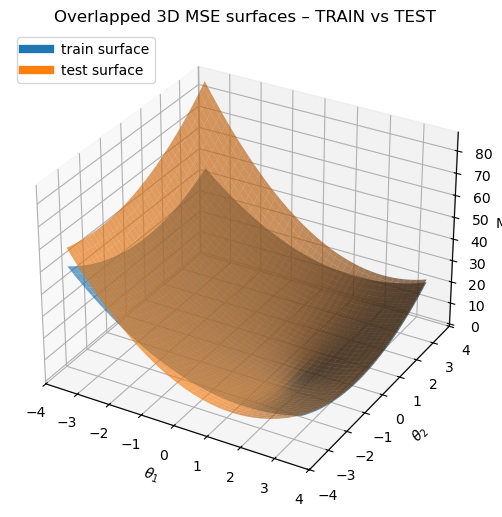

In [7]:
plot_overlapped_surface_3d(x_train, y_train, x_test, y_test)

A different way to plot 3 dimensional data is with contour plots, which are easier to read on 2D surfaces. Each line (contour) represents the bounds of a different loss area. 

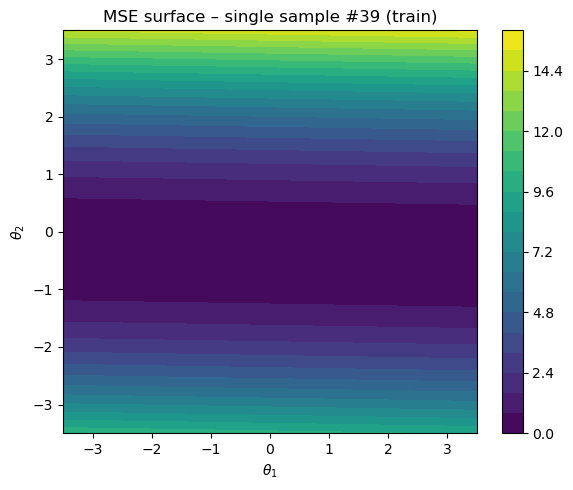

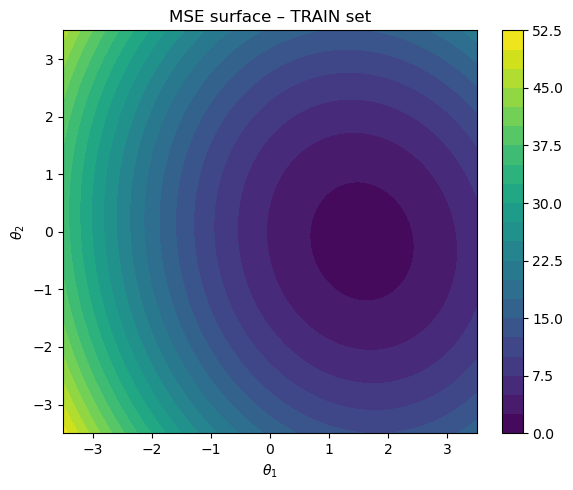

In [8]:

def plot_loss_surface_contour(
    x, y, title,
    grad=None, origin=None,
    w_lim=(-3.5, 3.5), b_lim=(-3.5, 3.5), n=200, levels=20
):
    # Compute loss surface
    W, B, L = loss_surface_grid(x, y, w_lim=w_lim, b_lim=b_lim, n=n)

    # --- Contour plot ---
    plt.figure(figsize=(6, 5))
    cs = plt.contourf(W.detach().numpy(), B.detach().numpy(), L.numpy(), 
                     levels=levels, 
                     cmap="viridis")
    plt.colorbar(cs)
   
    
    # Evaluation point (if provided)
    if origin is not None:
        w0, b0 = origin
        w0, b0 = w0.detach(), b0.detach()
        plt.scatter(w0, b0, color='red', s=40, label='evaluation point')

        # Gradient vector (if provided)
        if grad is not None:
            g_w, g_b = grad
            scale = 0.3
            plt.arrow(
                w0, b0,
                g_w * scale, g_b * scale,
                color='red',
                width=0.02,
                head_width=0.15,
                length_includes_head=True,
                label='gradient direction'
            )

    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$\theta_2$")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_loss_surface_contour(x_train[sample-1:sample], y_train[sample-1:sample], title=f'MSE surface – single sample #{sample} (train)')
plot_loss_surface_contour(x_train, y_train, title="MSE surface – TRAIN set")

# Manual Derivative
The question we want to answer: How do we need to change the parameters $\theta$ in order to minimize the loss. To answer this question, we will need to calculate the gradients. In this simple example, we can do this by hand (analytical solution). We also introduce the intermediate $z^{(i)} = f_\theta(x^{(i)})$:


\begin{align*}
\mathcal{L}_\theta &= \frac{1}{N} \sum_{i=1}^{N}  \ell(z^{(i)}, y^{(i)}) \\
\ell(z^{(i)}, y^{(i)}) &= (z^{(i)} - y^{(i)})^2 \\
z^{(i)} &=  \theta_0 x + \theta_1\\


\end{align*}

The gradient of the loss is equal to the average of the per sample loss (sum rule):

\begin{align*}

\nabla_{\theta} \mathcal{L}_{\text{train}}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \nabla_{\theta} \ell( f_{\theta}(x^{(i)}), y^{(i)})

\end{align*}

We can therefore look closer at a single sample loss.

The loss of a single sample with application of the chain rule can therefore be written as:

\begin{align*}

\frac{\partial \ell^{(i)}}{\partial \theta}
\;=\;
\frac{\partial \ell^{(i)}}{\partial z^{(i)}} \cdot
\frac{\partial z^{(i)}}{\partial \theta}

\end{align*}



Compute each factor:

1. **Local loss derivative:**

\begin{align*}
\frac{\partial \ell^{(i)}}{\partial z^{(i)}}
&= 2\,(z^{(i)} - y^{(i)})
\end{align*}

2. **Model Jacobian w.r.t. parameters (row vector):**
\begin{align*}
\frac{\partial z^{(i)}}{\partial \theta}
&=
\begin{bmatrix}
\frac{\partial z^{(i)}}{\partial \theta_0} &
\frac{\partial z^{(i)}}{\partial \theta_1}
\end{bmatrix}
=
\begin{bmatrix}
x^{(i)} & 1
\end{bmatrix}.
\end{align*}

Combine both terms (apply the chain rule):

\begin{align*}
\frac{\partial \ell^{(i)}}{\partial \theta}
&=
\frac{\partial \ell^{(i)}}{\partial z^{(i)}}
\frac{\partial z^{(i)}}{\partial \theta} \\[6pt]
&=
2\,(z^{(i)} - y^{(i)}) 
\begin{bmatrix}
x^{(i)} & 1
\end{bmatrix}.
\end{align*}

Component-wise, this gives:
\begin{align*}
\frac{\partial \ell^{(i)}}{\partial \theta_0} &= 2\,(\theta_0 x^{(i)}+\theta_1 - y^{(i)})\,x^{(i)}, \\[4pt]
\frac{\partial \ell^{(i)}}{\partial \theta_1} &= 2\,(\theta_0 x^{(i)}+\theta_1 - y^{(i)}).
\end{align*}


In [9]:
idx = int(torch.randint(len(x_train), (1,)))
x_i = x_train[idx:idx+1]
y_i = y_train[idx:idx+1]

# Initial parameters
theta = torch.tensor([2., 2.], requires_grad=True)


def analytic_grad_single(x, y, theta):
    resid = theta[0] * x + theta[1] - y
    dL_dw = 2.0 * resid * x
    dL_db = 2.0 * resid
    return dL_dw.squeeze(), dL_db.squeeze()

g_w_analytic, g_b_analytic = analytic_grad_single(x_i, y_i, theta)




# PyTorch AutoDiff
Instead of doing it automatically, PyTorch can do the work for us:

In [10]:
# If theta wasn't yet tracking (requiring) the gradient:
# theta.requires_grad = True

loss = mse_loss(theta, x_i, y_i)  # scalar (mean over the single sample)
loss.backward()
g_auto = theta.grad


As sanity check, we can also do numerical approximation:

In [11]:

def numerical_grad(x, y, theta, eps=1e-5):
    L = lambda ww, bb: mse_loss((ww, bb), x, y)
    dw = (L(theta[0] + eps, theta[1]) - L(theta[0], theta[1])) / eps
    db = (L(theta[0], theta[1] + eps) - L(theta[0], theta[1])) / eps
    return dw.item(), db.item()

g_w_num, g_b_num = numerical_grad(x_i, y_i, theta)


In [12]:
# Compact, well-formatted comparison output
print("=" * 60)
print(f"   Sample index: {idx}")
print(f"   Input (x, y): ({x_i.item():.3f}, {y_i.item():.3f})")
print(f"   Theta point : ({theta[0].item():.3f}, {theta[1].item():.3f})")
print("-" * 60)
print(f"{'Gradient':<15}{'Analytic':>15}{'Autograd':>15}{'Numerical':>15}")
print("-" * 60)
print(f"{'dL/dw':<15}{g_w_analytic.item():>15.6f}{g_auto[0].item():>15.6f}{g_w_num:>15.6f}")
print(f"{'dL/db':<15}{g_b_analytic.item():>15.6f}{g_auto[1].item():>15.6f}{g_b_num:>15.6f}")
print("=" * 60)


   Sample index: 8
   Input (x, y): (-1.738, -1.933)
   Theta point : (2.000, 2.000)
------------------------------------------------------------
Gradient              Analytic       Autograd      Numerical
------------------------------------------------------------
dL/dw                -1.586489      -1.586489      -1.588464
dL/db                 0.912717       0.912717       0.914931


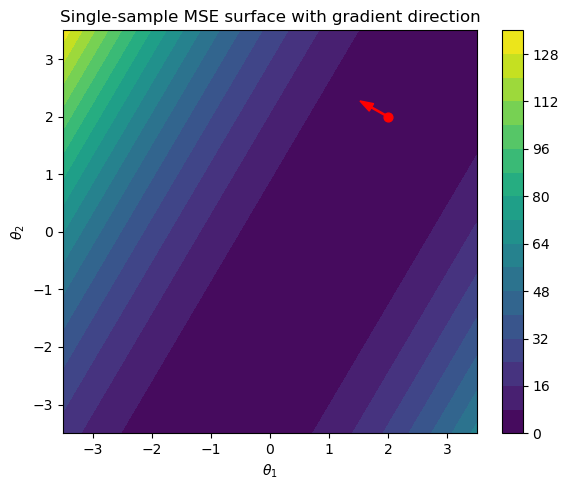

In [13]:
plot_loss_surface_contour(x_i, y_i,
                     title = "Single-sample MSE surface with gradient direction",
                     origin = theta, 
                     grad = g_auto)


# Gradient Descent

We can now use the gradients to optimize our parameters. In our example, we will do this manually. Usually, an Optimizer would help us with the update, but in this example we will do it ourselves.

In [14]:
# --- gradient descent trajectory ---
def gd_trajectory(x, y, origin, lr=0.05, steps=5):

    points = []
    theta = origin.detach().clone().requires_grad_(True)

    for _ in range(steps):
        
        loss = mse_loss(theta, x, y)
        loss.backward()

        # record current state
        points.append({
            "theta": theta.detach().clone(),
            "gtheta": theta.grad.detach().clone(),
            "loss": float(loss.detach())
        })
        
        # update
        with torch.no_grad():
            theta -= lr * theta.grad

        # clear grad
        theta.grad = None
        

    # log final point (zero gradient shown)
    with torch.no_grad():
        final_loss = mse_loss(theta, x, y)
    points.append({
        "theta": theta.detach().clone(),
        "gtheta": torch.zeros_like(theta),
        "loss": float(final_loss)
    })

    return points

Some final plots:

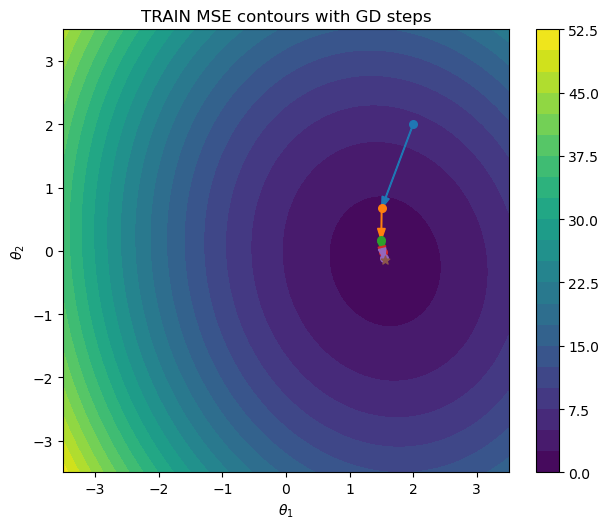

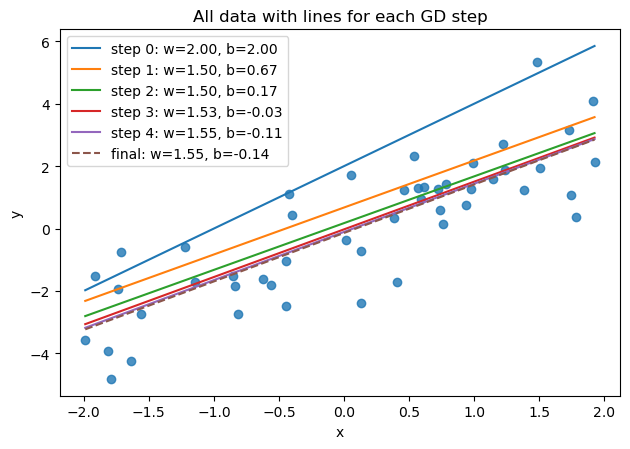

In [15]:

# --- contour plotting ---
def plot_contour_with_traj(x, y, points, title="MSE contours with GD trajectory",
                           w_lim=(-3.5, 3.5), b_lim=(-3.5, 3.5), n=220, levels=20):
    """
    Assumes loss_surface_grid(x, y, w_lim, b_lim, n)
    returns W, B, L (torch tensors for contour plot).
    """
    W, B, L = loss_surface_grid(x, y, w_lim=w_lim, b_lim=b_lim, n=n)
    plt.figure(figsize=(6.4, 5.4))
    cs = plt.contourf(W.numpy(), B.numpy(), L.numpy(), levels=levels)
    plt.colorbar(cs)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for t in range(len(points) - 1):
        w_t, b_t = points[t]["theta"][0].item(), points[t]["theta"][1].item()
        w_next, b_next = points[t + 1]["theta"][0].item(), points[t + 1]["theta"][1].item()
        c = colors[t % len(colors)]
        plt.scatter([w_t], [b_t], color=c, s=30)
        plt.arrow(w_t, b_t, w_next - w_t, b_next - b_t,
                  color=c, length_includes_head=True, head_width=0.12, width=0.01)

    w_last, b_last = points[-1]["theta"][0].item(), points[-1]["theta"][1].item()
    plt.scatter([w_last], [b_last],
                color=colors[(len(points) - 1) % len(colors)],
                s=40, marker="*")
    plt.xlabel(r"$\theta_1$"); 
    plt.ylabel(r"$\theta_2$"); 
    plt.title(title)
    plt.tight_layout()
    plt.show()


# --- line-plotting over data ---
def plot_data_with_lines(x_all, y_all, points, title="Data with lines from GD steps"):
    plt.figure(figsize=(6.4, 4.6))
    plt.scatter(x_all, y_all, alpha=0.8)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    xs = torch.linspace(float(x_all.min()), float(x_all.max()), 200)
    for t in range(len(points) - 1):
        w_t, b_t = points[t]["theta"][0].item(), points[t]["theta"][1].item()
        ys = w_t * xs + b_t
        plt.plot(xs, ys, color=colors[t % len(colors)],
                 label=f"step {t}: w={w_t:.2f}, b={b_t:.2f}")

    w_last, b_last = points[-1]["theta"][0].item(), points[-1]["theta"][1].item()
    ys_last = w_last * xs + b_last
    plt.plot(xs, ys_last, color=colors[(len(points) - 1) % len(colors)],
             linestyle="--", label=f"final: w={w_last:.2f}, b={b_last:.2f}")

    plt.xlabel("x"); plt.ylabel("y"); plt.title(title); plt.legend()
    plt.tight_layout(); plt.show()



traj = gd_trajectory(x_train, y_train, origin=theta, lr=0.3, steps=5)
plot_contour_with_traj(x_train, y_train, traj, title="TRAIN MSE contours with GD steps")
plot_data_with_lines(x_train, y_train, traj, title="All data with lines for each GD step")


In [16]:
theta = traj[-1]["theta"]
print(f"Train Loss: {mse_loss(theta, x_train, y_train):.3f}")
print(f"Test Loss: {mse_loss(theta, x_test, y_test):.3f}")

Train Loss: 1.441
Test Loss: 1.298


# Summary of important methods:

In [ ]:
# --- Creating tensors with gradient tracking ---
x = torch.randn(3, requires_grad=True)   # track ops for autograd
print(x.requires_grad)                   # True

# --- Turning tracking on/off ---
x.requires_grad = False                  # stop tracking in-place
print(x.requires_grad)                   # True
x.requires_grad_(True)                   # re-enable tracking

# --- Detaching (break gradient flow) ---
y = x.detach()                           # new tensor, no grad history
print(y.requires_grad)                   # False

# --- Temporarily disable gradient tracking (inference, eval) ---
with torch.no_grad():
    z = x * 2                            # no autograd history created

# --- Computing gradients ---
y = (x ** 2).sum()
y.backward()                             # dy/dx
print(f'Gradient of x: {x.grad}')

# --- Clearing old gradients before next backward ---
optimizer = torch.optim.SGD([x], lr=0.1) # more on optimizers soon
optimizer.zero_grad(set_to_none=True)    # best practice
x.grad = None                            # manual reset, not recommended in actual applications  



True
False
False
Gradient of x: tensor([ 0.0057,  1.1262, -0.0879])
